# Exemplo para tratamento de dados desbalanceados

Mais informações sobre o exemplo utilizado: https://github.com/jbrownlee/Datasets/blob/master/pima-indians-diabetes.names

Texto utilizado como leitura inicial: https://tatianaesc.medium.com/trabalhando-com-classes-desbalanceadas-em-problemas-machine-learning-29ee8db4a049

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score, auc, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN



## Funções que serão utilizadas ao longo do código

In [121]:
# Criando funcoes que serao utilizadas repetidas vezes ao longo do código
# Criando funcao que fara o fit do modelo e retornara as metricas de acuraria
def model_rf_fit(X_train, y_train, X_test, y_test):
    # Criando Modelo
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    # Fazendo o predict na base de teste e o predict proba
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)
    # Agora vamos verificar as métricas do modelo
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall=   recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc =  roc_auc_score(y_test, y_pred_proba[:, 1])
    # Precision-Recall Curve Plot of Recall (x) vs Precision (y).
    precision, rec, threshold = precision_recall_curve(y_test, y_pred_proba[:, 1])
    pr_auc =  auc(rec, precision)
    result_model = {'acuracia': acc, 'precisao': prec, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc, 'precision-recall_auc': pr_auc}
    return result_model

In [122]:
def graficos(X_train, y_train, X_tec, y_tec):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 linha, 2 colunas

    # Antes do balanceamento
    axes[0].scatter(
        X_train.iloc[:,1], X_train.iloc[:,5], 
        c=y_train, cmap='coolwarm', edgecolor='k', alpha=0.7
    )
    axes[0].set_title("Scatter Plot - Antes do Balanceamento")
    axes[0].set_xlabel(X_train.columns[1])
    axes[0].set_ylabel(X_train.columns[5])

    # Depois do balanceamento
    axes[1].scatter(
        X_tec.iloc[:,1], X_tec.iloc[:,5], 
        c=y_tec, cmap='coolwarm', edgecolor='k', alpha=0.7
    )
    axes[1].set_title("Scatter Plot - Depois do Balanceamento")
    axes[1].set_xlabel(X_tec.columns[1])
    axes[1].set_ylabel(X_tec.columns[5])

    plt.tight_layout()
    plt.show()

In [123]:
# Carregando dataset Pima Indians Diabetes, prever se um paciente desenvolvera diabetes ou nao
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# O dataset vem nome nas colunas
col_names = ['times_pregnant', 'glucose_concentration', 'blood_pressure', 'triceps_thickness', 'serum_insulin', 'body_mass', 'diabetes_pedigree',
'age', 'target']
dataset = pd.read_csv(url,names=col_names, delimiter=',')

# Vou eliminar 150 observações do y para o desbalanceamento aparecer mais
index = dataset[dataset['target'] == 1].sample(n=150, random_state=42).index
dataset = dataset.drop(index)
# Reseta os indices
dataset = dataset.reset_index(drop=True)

In [ ]:
# Verificando =~20% de desbalanceamento
dataset.groupby('target').size()/len(dataset)

target
0    0.809061
1    0.190939
dtype: float64

In [125]:
# Separando dataset em treino e teste
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

## Modelagem inicial sem tratar o desbalanceamento

In [126]:
normal_result = model_rf_fit(X_train, y_train, X_test, y_test)
normal_result

{'acuracia': 0.7983870967741935,
 'precisao': 0.45454545454545453,
 'recall': 0.20833333333333334,
 'f1': 0.2857142857142857,
 'roc_auc': 0.7552083333333334,
 'precision-recall_auc': 0.430280743572056}

## Métodos para tratar o desbalanceamento

### Radom UnderSampling

**Random Undersampling**: remove aleatoriamente exemplos da classe majoritária até equilibrar a proporção entre classes.


In [127]:
# Aplicando o metodo mais simples, remover aleatoriamente linhas da classe marjoritaria ate ficar na proporcao 1:1
under=RandomUnderSampler(sampling_strategy=1)
X_under, y_under = under.fit_resample(X_train, y_train)

In [128]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_under.sum()/len(y_under))

Proporções antes 0.1902834008097166
Proporções depois 0.5


In [129]:
random_under_result = model_rf_fit(X_under, y_under, X_test, y_test)
random_under_result

{'acuracia': 0.7419354838709677,
 'precisao': 0.39473684210526316,
 'recall': 0.625,
 'f1': 0.4838709677419355,
 'roc_auc': 0.8060416666666668,
 'precision-recall_auc': 0.4929371366597463}

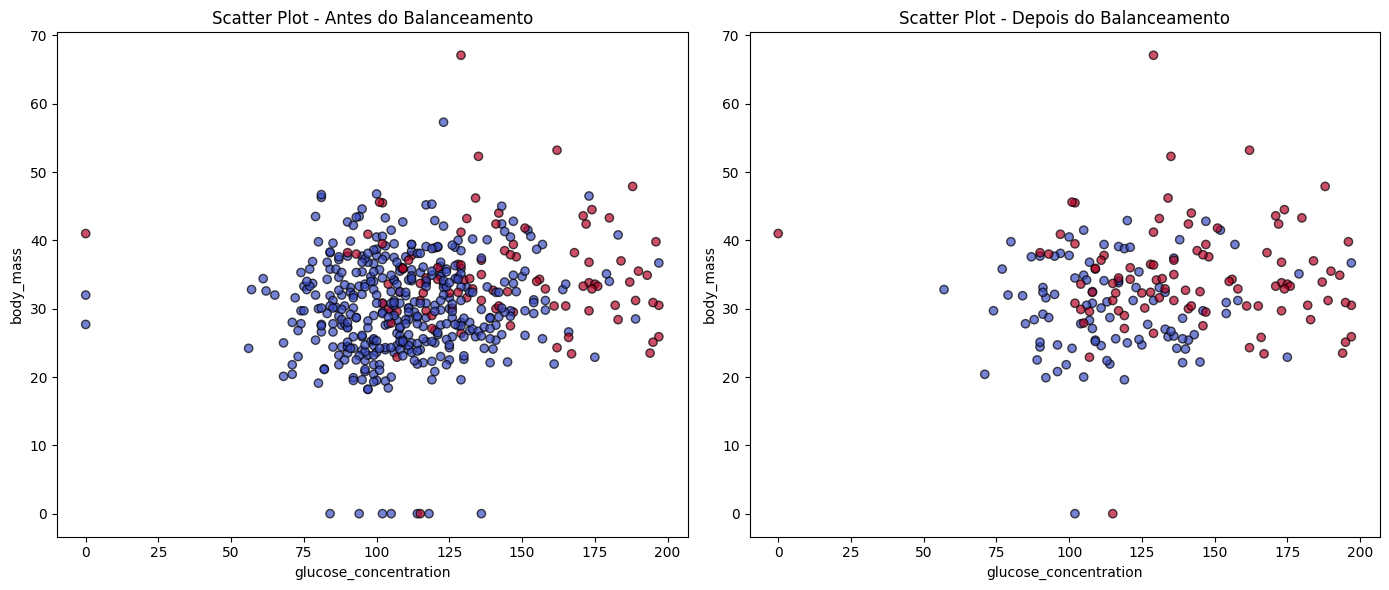

In [130]:
graficos(X_train, y_train, X_under, y_under)

### Tomek Link

**Tomek Link**: identifica pares de exemplos de classes opostas que são vizinhos próximos e remove o exemplo da classe majoritária, ajudando a limpar fronteiras de decisão confusas.


In [ ]:
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

In [132]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_tomek.sum()/len(y_tomek))
print(Counter(y_train))
print(Counter(y_tomek))

Proporções antes 0.1902834008097166
Proporções depois 0.2025862068965517
Counter({0: 400, 1: 94})
Counter({0: 370, 1: 94})


In [133]:
tomek_under_result = model_rf_fit(X_tomek, y_tomek, X_test, y_test)
tomek_under_result

{'acuracia': 0.8064516129032258,
 'precisao': 0.5,
 'recall': 0.3333333333333333,
 'f1': 0.4,
 'roc_auc': 0.77,
 'precision-recall_auc': 0.4778649401877503}

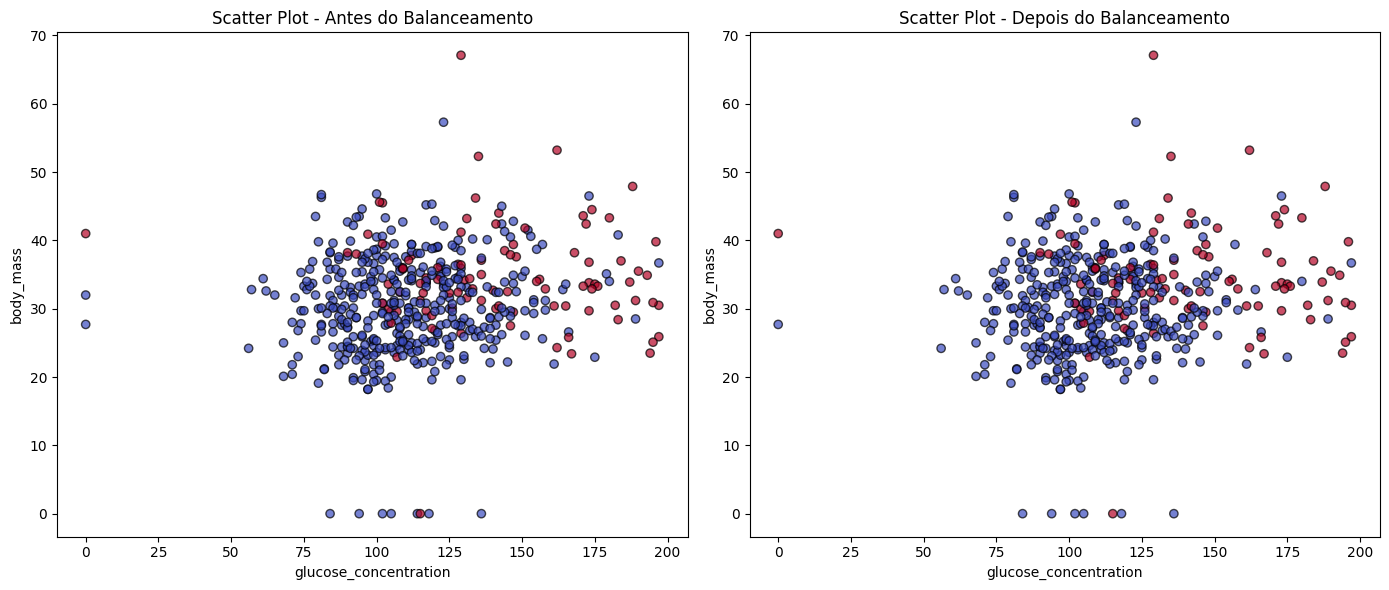

In [134]:
graficos(X_train, y_train, X_tomek, y_tomek)

### Edited Nearest Neighbors Rules (ENN)

**Edited Nearest Neighbors (ENN):** remove amostras (geralmente da classe majoritária) que não concordam com a maioria de seus vizinhos mais próximos, eliminando ruídos e refinando a fronteira de decisão.


In [135]:
# Aplicando o metodo mais simples, remover aleatoriamente linhas da classe marjoritaria ate ficar na proporcao 1:1
enn = EditedNearestNeighbours()
X_enn, y_enn = enn.fit_resample(X_train, y_train)

In [136]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_enn.sum()/len(y_enn))
print(Counter(y_train))
print(Counter(y_enn))

Proporções antes 0.1902834008097166
Proporções depois 0.2647887323943662
Counter({0: 400, 1: 94})
Counter({0: 261, 1: 94})


In [137]:
enn_under_result = model_rf_fit(X_enn, y_enn, X_test, y_test)
enn_under_result

{'acuracia': 0.75,
 'precisao': 0.3939393939393939,
 'recall': 0.5416666666666666,
 'f1': 0.45614035087719296,
 'roc_auc': 0.7702083333333333,
 'precision-recall_auc': 0.40408222373854613}

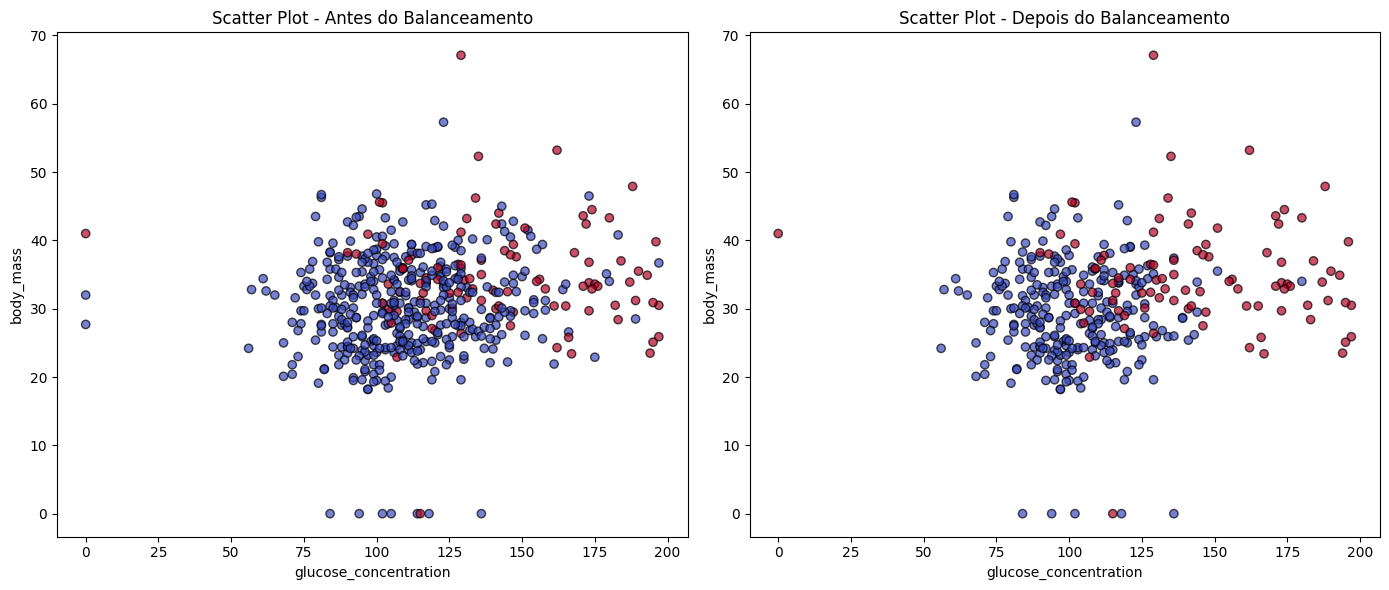

In [138]:
graficos(X_train, y_train, X_enn, y_enn)

### Random OverSampling

**Random OverSampling:** duplica aleatoriamente exemplos da classe minoritária para equilibrar a distribuição entre classes no conjunto de dados.

In [139]:
# Aplicando o metodo mais simples, remover aleatoriamente linhas da classe marjoritaria ate ficar na proporcao 1:1
over=RandomOverSampler(sampling_strategy=1)
X_over, y_over = over.fit_resample(X_train, y_train)

In [140]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_over.sum()/len(y_over))

Proporções antes 0.1902834008097166
Proporções depois 0.5


In [141]:
random_over_result = model_rf_fit(X_over, y_over, X_test, y_test)
random_over_result

{'acuracia': 0.7983870967741935,
 'precisao': 0.47058823529411764,
 'recall': 0.3333333333333333,
 'f1': 0.3902439024390244,
 'roc_auc': 0.7875,
 'precision-recall_auc': 0.45422490392380227}

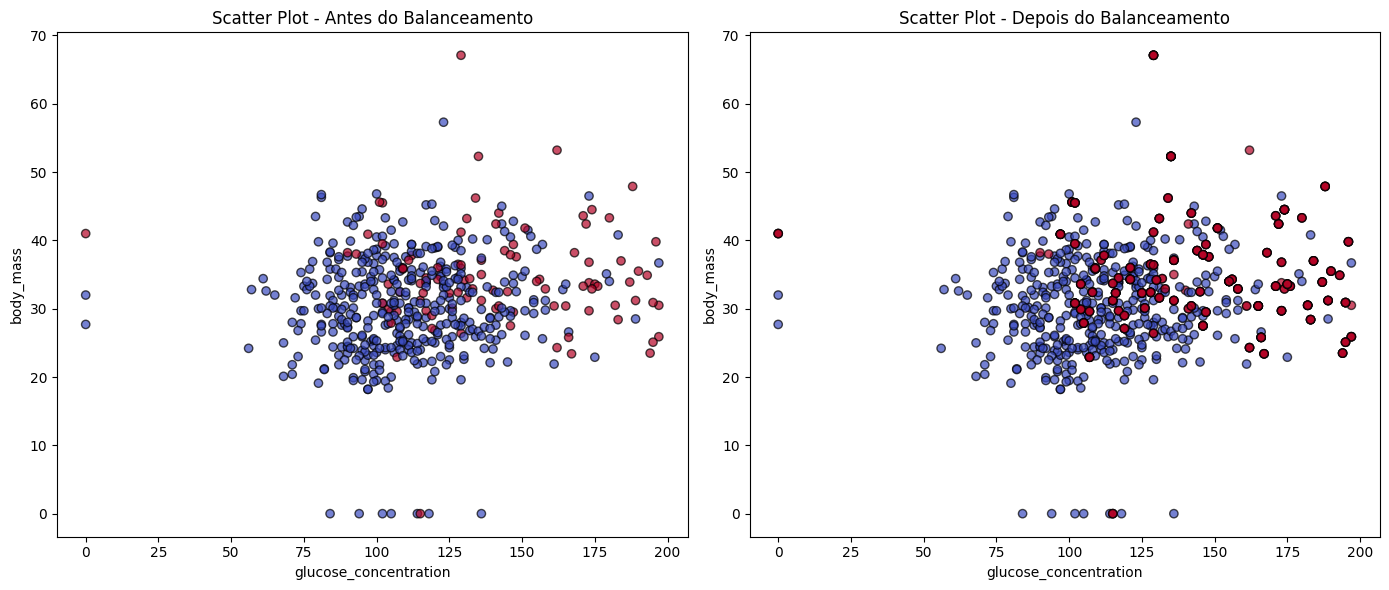

In [142]:
graficos(X_train, y_train, X_over, y_over)

### SMOTE 

**SMOTE (Synthetic Minority Oversampling Technique)**: cria exemplos sintéticos da classe minoritária interpolando os exemplos existentes, em vez de apenas duplicá-los, para aumentar a classe minoritária.



In [143]:
# Aplicando o metodo mais simples, duplicar elementos da classe minoritaria ate atingir a proporcao 1:1
over_smote=SMOTE(sampling_strategy=1)
X_over_smote, y_over_smote = over_smote.fit_resample(X_train, y_train)

In [144]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_over.sum()/len(y_over_smote))

Proporções antes 0.1902834008097166
Proporções depois 0.5


In [145]:
random_over_smote_result = model_rf_fit(X_over_smote, y_over_smote, X_test, y_test)
random_over_smote_result

{'acuracia': 0.7983870967741935,
 'precisao': 0.48,
 'recall': 0.5,
 'f1': 0.4897959183673469,
 'roc_auc': 0.8131250000000001,
 'precision-recall_auc': 0.49044821161434266}

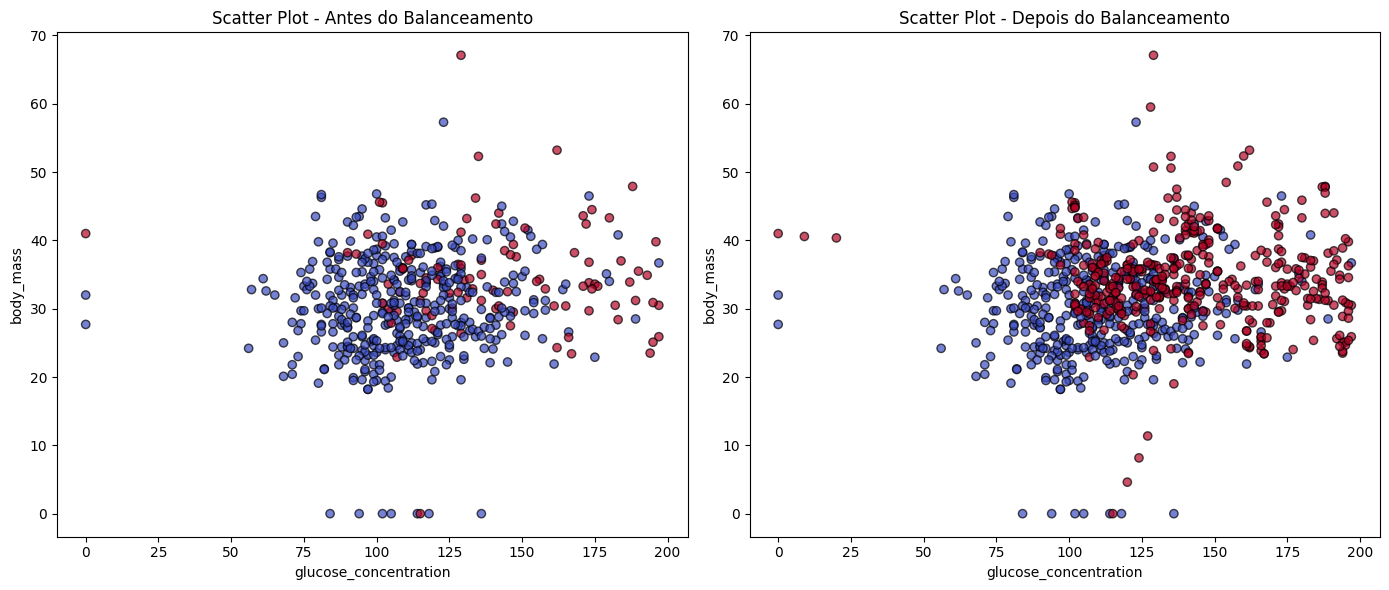

In [146]:
graficos(X_train, y_train, X_over_smote, y_over_smote)

### Bordeline-SMOTE 

**Borderline-SMOTE**: gera exemplos sintéticos da classe minoritária, mas apenas próximos à fronteira de decisão entre classes (ou seja, onde os exemplos minoritários estão mais próximos de exemplos da classe majoritária), focando nos casos mais difíceis de classificar.

In [147]:
# Aplicando o metodo mais simples, duplicar elementos da classe minoritaria ate atingir a proporcao 1:1
over_smote_1=BorderlineSMOTE(sampling_strategy=1)
X_over_smote_1, y_over_smote1 = over_smote_1.fit_resample(X_train, y_train)

In [148]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_over.sum()/len(y_over_smote1))

Proporções antes 0.1902834008097166
Proporções depois 0.5


In [149]:
random_over_smote_result_1 = model_rf_fit(X_over_smote_1, y_over_smote1, X_test, y_test)
random_over_smote_result_1

{'acuracia': 0.7741935483870968,
 'precisao': 0.42857142857142855,
 'recall': 0.5,
 'f1': 0.46153846153846156,
 'roc_auc': 0.7895833333333334,
 'precision-recall_auc': 0.5198548544464894}

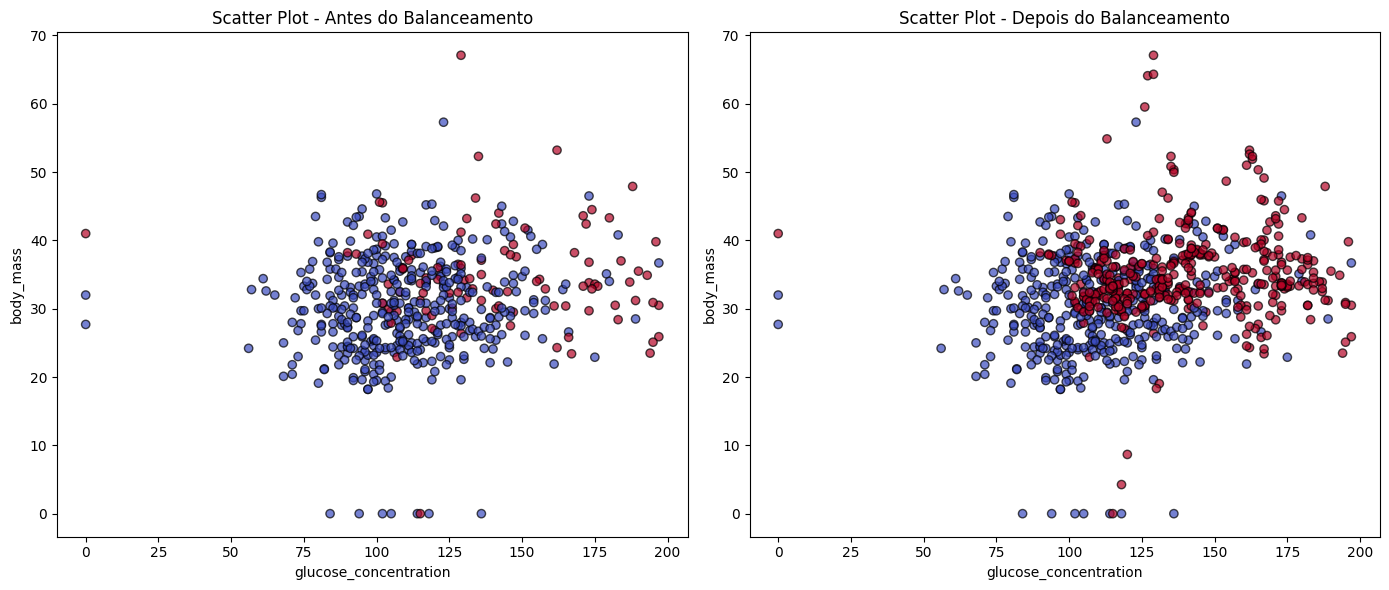

In [150]:
graficos(X_train, y_train, X_over_smote_1, y_over_smote1)

### ADASYN 

**ADASYN (Adaptive Synthetic Sampling)**: gera exemplos sintéticos da classe minoritária de forma adaptativa, criando mais exemplos em regiões onde os dados minoritários são mais difíceis de aprender, ou seja, onde há maior concentração de exemplos da classe majoritária próximos.


In [151]:
# Aplicando o metodo mais simples, duplicar elementos da classe minoritaria ate atingir a proporcao 1:1
over_ada=ADASYN(sampling_strategy=1)
X_ada, y_ada = over_ada.fit_resample(X_train, y_train)

In [152]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_over.sum()/len(y_ada))

Proporções antes 0.1902834008097166
Proporções depois 0.5082592121982211


In [153]:
random_over_smote_result_1 = model_rf_fit(X_ada, y_ada, X_test, y_test)
random_over_smote_result_1

{'acuracia': 0.8064516129032258,
 'precisao': 0.5,
 'recall': 0.5,
 'f1': 0.5,
 'roc_auc': 0.8060416666666667,
 'precision-recall_auc': 0.5051764796801727}

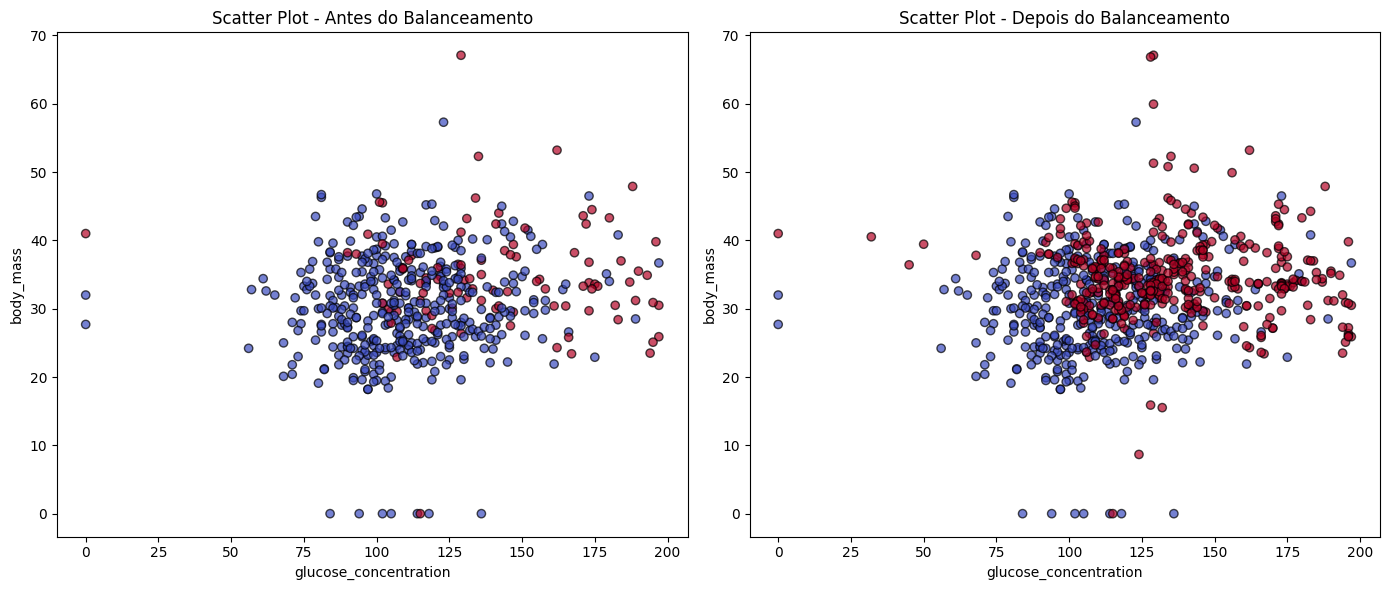

In [154]:
graficos(X_train, y_train, X_ada, y_ada)

### SMOTEEN (SMOTE + ENN) UnderSampling e OverSampling 
**SMOTEENN (SMOTE + ENN)**: combina **oversampling** com SMOTE para criar exemplos sintéticos da classe minoritária e **undersampling** com Edited Nearest Neighbors (ENN) para remover exemplos mal classificados de **todas as classes**, limpando o conjunto de dados e melhorando a fronteira de decisão.


In [155]:
# Aplicando o metodo mais simples, duplicar elementos da classe minoritaria ate atingir a proporcao 1:1
over_under=SMOTEENN()
X_over_under, y_over_under= over_under.fit_resample(X_train, y_train)

In [156]:
# Devemos fazer essas técnicas no conjunto de treino do modelo
# Verificando proporção da classe positiva
print('Proporções antes', y_train.sum()/len(y_train))
print('Proporções depois', y_over_under.sum()/len(y_over_under))
print(Counter(y_train))
print(Counter(y_over_under))

Proporções antes 0.1902834008097166
Proporções depois 0.59391771019678
Counter({0: 400, 1: 94})
Counter({1: 332, 0: 227})


In [157]:
over_under_result = model_rf_fit(X_over_under, y_over_under, X_test, y_test)
over_under_result

{'acuracia': 0.6854838709677419,
 'precisao': 0.32558139534883723,
 'recall': 0.5833333333333334,
 'f1': 0.417910447761194,
 'roc_auc': 0.779375,
 'precision-recall_auc': 0.40800571542071495}

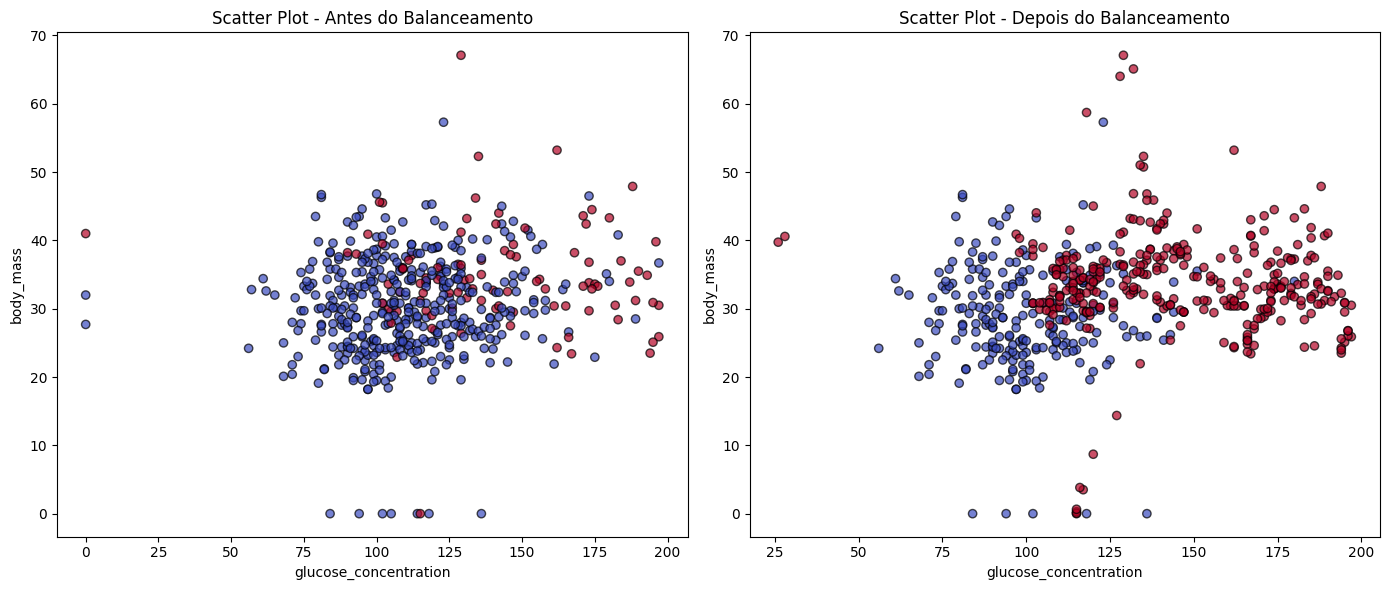

In [158]:
graficos(X_train, y_train, X_over_under, y_over_under)